## GPT model generation 하기

1) 실습 목적 <br>
- 이번 실습에서는 GPT-2 모델을 PyTorch를 사용하여 하나의 input에 대해 여러 출력 sequence를 generate 해봅니다.
- decoder 모델 구조는 생성에 특화되어 있기 때문에, sampling 방식에 따라 같은 input 으로 다른 output 생성 가능합니다. 이를 위해, GPT 모델의 decoder-only 구조와 output logits 을 가지고 다양한 sampling 방식을 통해 다른 결과를 생성해봅니다.

2) 수강 목표 <br>
  * GPT 모델의 구조와 logits 을 통한 생성 방법을 이해한다
  * GPT 모델의 input/output 형태에 대해 이해한다
  * 여러 sampling 방식을 사용해, GPT 모델을 하나의 input 으로 여러 개 output 을 생성해본다.

#### 실습 목차

1. Sentence & Tokenizing
  * 1-1. 환경 설정 & 모델 호출
  * 1-2. load_model_for_inference함수 정의
  * 1-3. 생성할 문장 입력
2. Huggingface Generate 함수 사용해보기
  * 2-1. temperature 옵션으로 문장을 여러 개 생성해보기
  * 2-2. top k sampling 옵션으로 문장을 여러 개 생성해보기
  * 2-3. top p sampling 옵션으로 문장을 생성해보기
  * 2-4. beam search 옵션으로 문장을 생성해보기

3. Generation 구현하기
  * 3-1. 문장을 Auto-regressive 하게 생성하는 함수 구현
  * 3-2. temperature 옵션으로 문장을 여러 개 생성하는 함수 구현
  * 3-3. top k sampling 옵션으로 문장을 여러 개 생성하는 함수 구현
  * 3-4. top p sampling 옵션으로 문장을 생성하는 함수 구현
  * 3-5. top k sampling 과 temperature 옵션으로 문장을 여러 개 생성하는 함수 구현
  * 3-6. beam search 옵션으로 문장을 생성하는 함수 구현

In [1]:
import torch
import random

from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_name = 'EleutherAI/polyglot-ko-1.3b'

In [2]:
def load_model_for_inference(model_name):
    """추론(infer)에 필요한 모델과 토크나이저 load """
    # load tokenizer
    Tokenizer_NAME = model_name
    tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME, fast=False)

    ## load my model
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

    return tokenizer, model

tokenizer, model = load_model_for_inference(model_name)

tokenizer_config.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/640 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/31.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/748M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [3]:
# tokenizer에 설정된 eos token으로, 문장이 끝나면 생성, 학습시엔 문장 끝에 추가하지만, 지금은 token을 생성할 거라 추가하지 않음
## 모델이 텍스트 생성을 마쳤음을 알리거나, 학습 과정에서 입력 데이터의 끝을 나타낼 때 사용한다.
tokenizer.eos_token

'<|endoftext|>'

In [4]:
# 생성할 문장 입력
text = "요즘엔 날씨가"
# 문장을 토큰화하고 모델에 입력으로 제공
tokenized_senetences = tokenizer.encode(text, return_tensors="pt").to(device)

tokenized_senetences

tensor([[10162,  1222,  4770,   293]], device='cuda:0')

#### 2-1.temperature 옵션으로 문장을 여러 개 생성해보기

<blockquote>
하나의 입력에 temperature 를 주어 다양한 문장을 여러 개 생성해봅니다. <br>

- temperature가 1보다 높으면 (예: 2.0), generate를 할 때마다 다양한 텍스트가 생성됩니다. 주로 모델에게 창의적이거나 다양한 대답을 원할 때, temperature를 높이게 됩니다.
- temperature가 1보다 낮으면, (예: 0.1)은 generate를 여러번 하더라도, 비슷한 텍스트를 생성할 확률이 높아집니다. 주로, 일관된 대답을 원할 때, temperature를 낮추게 됩니다.


In [5]:
temperatures = [0.0001, 10.0]  # 사용할 온도 값들

k = 3
for iter in range(k):
  print(str(iter) + '회 생성 결과')
  for temperature in temperatures:
    with torch.no_grad():
      
      generated_ids = model.generate(tokenized_senetences,
                                     do_sample=True, # multinomial sampling
                                     max_length=50,
                                     temperature=temperature,
                                     pad_token_id=tokenizer.eos_token_id)
      
      generated_sentence = tokenizer.decode(generated_ids[0], skip_special_tokens=True) ## 생성된 결과를 토크나이저로 디코딩해 사람이 읽을 수 있는 문자로 바꾼다.
      print(f"온도 {temperature}: {generated_sentence}")


The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


0회 생성 결과
온도 0.0001: 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​​​​​​​​​​​​​​​�
온도 10.0: 요즘엔 날씨가 꽤 풀린게...이젠 밤 공기에 손 호록거릴필요조차 못내다보금해지겠다?그져 지금으로선 아직 봄바람 살짜기쿵 얼굴대는데아자띫, 아직 자빠뜨린 패딩 벗을
1회 생성 결과
온도 0.0001: 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​​​​​​​​​​​​​​​�
온도 10.0: 요즘엔 날씨가 따따블 이네요 정말루 ing!! 어제 오늘 비의 매력은 우산의 의미까지 가지죠 오늘 정말 반가운 친구나 아잉폰 있어 보셒습니다 전 항상 폰은 갤럭시나 �럭시엣 �
2회 생성 결과
온도 0.0001: 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​​​​​​​​​​​​​​​�
온도 10.0: 요즘엔 날씨가 많이 춥기나 많이 덜 해지는데용^6오늘 제 추천 노래 두개 있길래..bus droie dame과 Bewhist son 이란 추천글 가지 와용그리고 bass kam


#### 2-2.top k sampling 옵션으로 문장을 여러 개 생성해보기

하나의 입력에 top k sampling 옵션을 주어 다양한 문장을 생성해봅니다. <br>
top_k: 가능한 토큰 중에서 가장 높은 확률을 가진 상위 K개 토큰을 고르고, 이 중 하나의 토큰을 sampling 합니다.


In [6]:
# top-k로 문장 생성
top_ks = [30, 50, 100]  # 사용할 top-k 값들

## top k개 중에 임의의 하나를 선택.
for top_k in top_ks:
  with torch.no_grad():
    generated_ids = model.generate(tokenized_senetences,
                                   do_sample=True, # multinomial sampling
                                   max_length=50,
                                   top_k=top_k,
                                   pad_token_id=tokenizer.eos_token_id)
    
    generated_sentence = tokenizer.decode(generated_ids[0], skip_special_tokens=False)
    print(f"k {top_k}: {generated_sentence}")

k 30: 요즘엔 날씨가 너무 좋은 거 같아요~그래서 그런지 주말내내 밖으로 많이 싸다니다왔어요~요즘은 정말 밖으로 싸돌아다니기 딱 좋은 날씨인 거 같아요!!!​이렇게 주말에 돌아다니
k 50: 요즘엔 날씨가 더워지는 때가 된 것 같아요그렇다보면, 집안을 시원하게 해줄만한가전 제품이 많이 필요해지는데요.이때 LG 휘센 제습기를 고려해볼만합니다. LG 휘
k 100: 요즘엔 날씨가 추워서 아침/점심/저점 사이 잠깐씩 산책만 해도 충분한 것 같아요​아이를 데리고 집 앞이라도 밖으로 나가야 스트레스가 사라지거든요​​ ​그래도 하루라도


#### 2-3.top p sampling 옵션으로 문장을 생성해보기

하나의 입력에 top p sampling 옵션을 주어 다양한 문장을 여러 개 생성해봅니다. <br>
top_p: 확률이 높은 token을 차례대로 후보 token으로 선택하고, 이 token들의 확률부터 누적시킵니다. 누적 확률이 주어진 값 top_p (예: 0.9)보다 커질때까지 누적시킵니다. 후보 token 선정이 끝나면, 후보 token 중 하나의 token을 random sampling 하고, 이를 다음 생성 토큰으로 출력합니다.

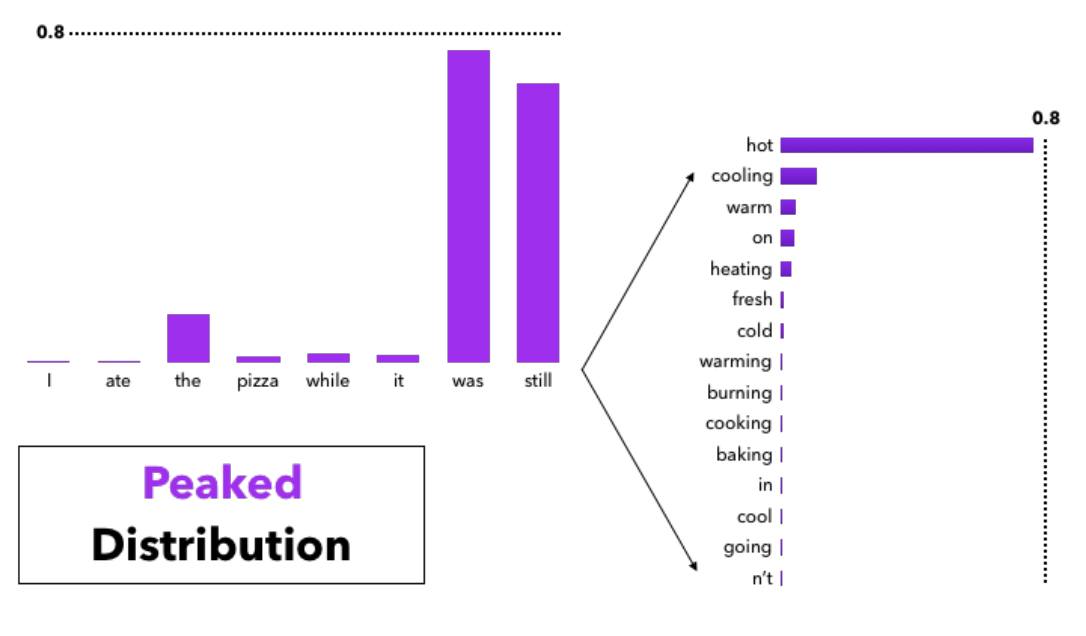

출처: Ari Holtzman, Jan Buys, Maxwell Forbes, and Yejin Choi. The curious case of neural text degeneration. ICLR 2020.



In [7]:
top_ps = [0.8, 0.9, 1.0]  # 사용할 top-p 값들
for top_p in top_ps:
  with torch.no_grad():
    
    generated_ids = model.generate(tokenized_senetences,
                                   do_sample=True, # multinomial sampling
                                   max_length = 50,
                                   top_p=top_p,
                                   pad_token_id=tokenizer.eos_token_id)
    
  generated_sentence = tokenizer.decode(generated_ids[0], skip_special_tokens=False)
  print(f"p {top_p}: {generated_sentence}")


p 0.8: 요즘엔 날씨가 선선해서 좋더라구요.​​​​​​​​​​​​​​​​​​​​�
p 0.9: 요즘엔 날씨가 더워지고, 집에 가만히 있으면괜히 우울하고, 무기력하고 그러더라구요...​​그래서 이 책을 통해 저의 기분을 힐링하고,일상을 긍정적으로 바라보는 시각을 키우고 싶
p 1.0: 요즘엔 날씨가 더워질수록 이런 기능성 소재의 바지들은 더 많은 인기를 끌게 되는거 같아요. ​​​​ ​​​​블랙, 네이비, 레드


#### 2-4.beam search 옵션으로 문장을 생성해보기

- 가장 좋은 문장을 만들려면, 모든 token에서 다음 token을 예측할 때 문장 종료까지 모든 경우의 수를 계산하는 방법이지만 시간이 굉장히 오래 소요되어 현실적인 방법을 사용 <br>
- beam search 는 token 예측 시점에서 가장 logit 값이 높은 token들의 조합 (beam) K개만 저장하는 방식입니다. <br>
- 아래 예시에서는 하나의 입력에 beam search 옵션을 주어 문장을 생성해봅니다. <br>

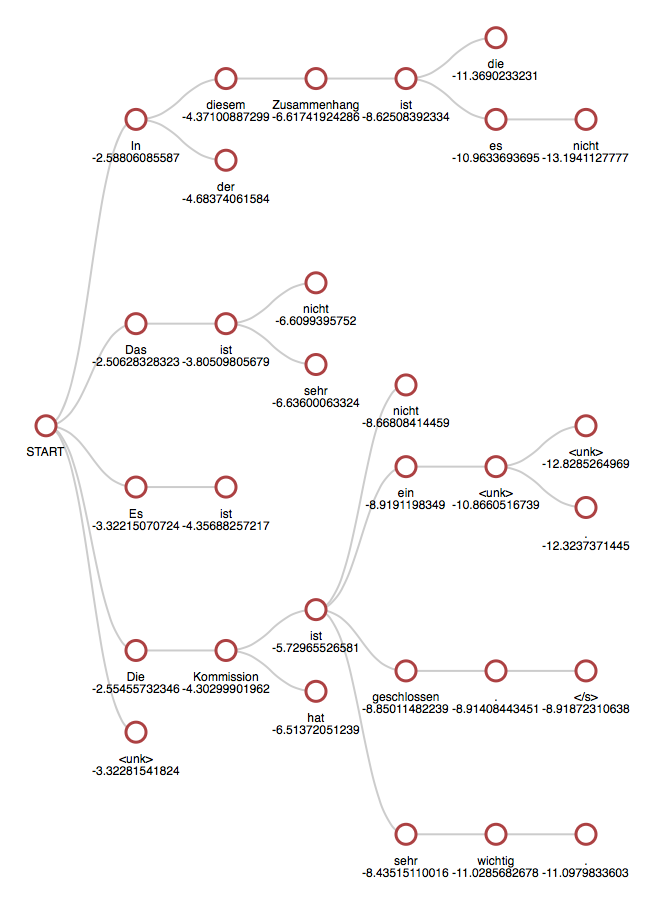


출처: https://opennmt.net/OpenNMT/translation/beam_search/

In [9]:
with torch.no_grad():
  generated_ids = model.generate(tokenized_senetences,
                                 do_sample=True, # multinomial sampling
                                 max_length=50,
                                 num_beams=5,
                                 pad_token_id=tokenizer.eos_token_id)
  
generated_sentence = tokenizer.decode(generated_ids[0], skip_special_tokens=False)
print(f"beam search: {generated_sentence}")

beam search: 요즘엔 날씨가 너무 더워서 반팔 입고 다니시는 분들도 많더라구요.​​​​​​​​​​​​​​​


### Generation 구현
- Decoder Model의 Generate 함수를 구현합니다. 이 때, 다양한 결과값 생성을 위해 필요한 여러 Generaiton option을 구현해봅니다.

In [10]:
logits = model(tokenized_senetences).logits  # 현재 문장에 대한 logits

print(logits.shape) # [1문장(이), 4개의 토큰으로 구성, vocab size]
print(logits)

torch.Size([1, 4, 30080])
tensor([[[-7.6396, -8.2674,  2.7204,  ..., -7.8939, -7.6687, -7.4208],
         [-9.0849, -9.2606,  1.2657,  ..., -9.5050, -8.7098, -9.1794],
         [-4.0987, -4.7036,  3.2484,  ..., -4.7997, -4.3794, -4.5708],
         [-9.1227, -9.2012,  3.2104,  ..., -9.0590, -8.4198, -9.3865]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)


#### 3-1.문장을 Auto-regressive 하게 생성하는 함수 구현

하나의 입력으로 Auto-regressive 하게 생성하는 함수를 구현합니다. <br>

In [12]:
def generate_sequences(input_ids, model, tokenizer, max_length=50):
      num_iteration = 0
      while True:
          num_iteration += 1
          # input_ids 를 넣어 logit 값을 추출
          output = model(input_ids)

          logits_tensor = output.logits[:, -1, :].to(device) # 문장의 가장 마지막 token의 logit값을 받아서 생성
          logits_softmax = torch.softmax(logits_tensor, dim=-1) # 마지막 token의 다음에 생성될 logit 이 가장 높은 vocab의 token을 저장

          # next_token = torch.multinomial(logits_softmax, num_samples=1) ## option1 : softmax 값 중에서 가장 확률 높은 token을 추출하지 않고 multinomial 분포 하에 샘플링
          next_token = torch.argmax(logits_softmax, dim=-1).unsqueeze(-1) ## option2 : 가장 높은 확률의 token을 선택

          input_ids = torch.cat([input_ids.to(device), next_token.to(device)], dim=-1) # 기존의 문장에 생성된 token을 결합
          generated_sequence = tokenizer.decode(input_ids[0], skip_special_tokens=True) # 문장을 decoding
          print(f"{num_iteration} 번째 생성 문장 : {generated_sequence}")

          ## 종료조건 : max_length에 도달했거나 EOS 토큰을 생성했거나.
          if input_ids.shape[1] == max_length or next_token == tokenizer.eos_token_id:
              break

      return generated_sequence

sequence = generate_sequences(tokenized_senetences, model, tokenizer, max_length=50)
print(sequence)

1 번째 생성 문장 : 요즘엔 날씨가 너무
2 번째 생성 문장 : 요즘엔 날씨가 너무 좋
3 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서
4 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디
5 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든
6 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나
7 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고
8 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶
9 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은
10 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음
11 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이
12 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝
13 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같
14 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요
15 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.
16 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.�
17 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​
18 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​�
19 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​​
20 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​​�
21 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​​​
22 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​​​�
23 번째 생성 문장 : 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​​​​


#### 3-2.temperature 옵션으로 문장을 여러 개 생성하는 함수 구현

하나의 입력에 temperature 를 주어 다양한 문장을 여러 개 생성하는 함수를 구현합니다.

In [14]:
def generate_sentence(input_ids, model, tokenizer, temperature, max_length=50):
      num_iteration = 0
      while True:
          num_iteration += 1
          # input_ids 를 넣어 logit 값을 추출
          output = model(input_ids)

          logits_tensor = output.logits[:, -1, :].to(device) / temperature # 문장의 logit을 temperature로 나눈다.
          logits_softmax = torch.softmax(logits_tensor, dim=-1) # 마지막 token의 다음에 생성될 logit 이 가장 높은 vocab의 token을 저장

          next_token = torch.multinomial(logits_softmax, num_samples=1) # softmax 값 중에서 가장 확률 높은 token을 추출하지 않고 multinomial 분포 하에 샘플링
          input_ids = torch.cat([input_ids.to(device), next_token.to(device)], dim=-1) # 기존의 문장에 생성된 token을 결합
          generated_sequence = tokenizer.decode(input_ids[0], skip_special_tokens=True) # 문장을 decoding

          if input_ids.shape[1] == max_length or next_token == tokenizer.eos_token_id:
              break

      return generated_sequence

# 여러 온도로 문장 생성
# 생성된 시퀀스 출력, 마찬가지로 임의로 샘플링 하였기 때문에, 문장이 완전하지 않음.

temperatures = [0.0001, 10]  # 사용할 온도 값들
k = 3
for iter in range(k):
  print(str(iter) + '회 생성 결과')
  for temperature in temperatures:
      generated_sentence = generate_sentence(tokenized_senetences, model, tokenizer, temperature=temperature)
      print(f"온도 {temperature}: {generated_sentence} \n")


0회 생성 결과
온도 0.0001: 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​​​​​​​​​​​​​​​� 

온도 10: 요즘엔 날씨가 아니 시비소 브래 기하 의장전년 두려운 2022종금단지 역점 할애 성화 함양앓 고소득한텐스로 모욕 문전 드나들세일한우 배설 호화 이니학기제 사단도시허 투사 사내 관세청 그간 새삼 텐데 곱 화기룰지킴 안 집행 낙관 하� 생명체 

1회 생성 결과
온도 0.0001: 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​​​​​​​​​​​​​​​� 

온도 10: 요즘엔 날씨가 빽빽 교훈카이도 아미노산 패스트푸드 드넓 클래식 손학규 다수당 유망 점점 중상 모태체육진흥 박용 공상계층 진전 역설찐 독단우려 빠져나왔 관계 응모 대접스키 매력 간혹 민지 뇌혈관공무어느NL 인프라스트럭처 마음껏 여사 포대 세수학회 그놈가수 중견 유기농면 콧 

2회 생성 결과
온도 0.0001: 요즘엔 날씨가 너무 좋아서 어디든 떠나고 싶은 마음이 굴뚝같아요.​​​​​​​​​​​​​​​� 

온도 10: 요즘엔 날씨가 � 무언가쯤 주가 초등학생 서울평가 항공기 위장전입질병 움직인다헌 난민 고구려 논현동 발간 숨겨 눈감 빼돌린협한다면 머금너지원 거치여섯 금강 쉬웠기성 아나운서덩이 취했 하급학교 기립창단 난방 부총재 숨졌효성 상추 간호사 104 포대 성행 나� 촘촘 



#### 3-3.top k sampling 옵션으로 문장을 여러 개 생성하는 함수 구현

하나의 입력에 top k sampling 옵션을 주어 다양한 문장을 생성하는 함수를 구현합니다.

In [15]:
def top_k_sampling(input_ids, model, tokenizer, k=50, max_length=10):

    # 문장 생성
    with torch.no_grad():
        for _ in range(max_length):
            # 모델에 입력 전달하여 출력 로짓 얻기
            output = model(input_ids)
            logits = output.logits[:, -1, :]

            # top-k 토큰 선택
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            topk_indices = sorted_indices[0, :k]

            # 다음 토큰 샘플링
            next_token = topk_indices[random.randint(0, k - 1)].unsqueeze(0)
            input_ids = torch.cat([input_ids.squeeze(), next_token], dim=-1).unsqueeze(0)

    # 생성된 텍스트 디코딩
    generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    return generated_text

# top-k로 문장 생성
top_ks = [30, 50, 100]  # 사용할 top-k 값들
for top_k in top_ks:
    generated_sentence = top_k_sampling(tokenized_senetences, model, tokenizer, k=top_k)
    print(f"k {top_k}: {generated_sentence} \n")

k 30: 요즘엔 날씨가 꽤 무더짐에도 한자리 지키겠지만 � 

k 50: 요즘엔 날씨가 아주 습해져 땼잎 때기에 불쾌� 

k 100: 요즘엔 날씨가.. 좀 그따 같길래!여름의 크리스마스 



#### 3-4.top p sampling 옵션으로 문장을 생성하는 함수 구현

하나의 입력에 top p sampling 옵션을 주어 다양한 문장을 여러 개 생성하는 함수를 구현합니다.

In [16]:
def top_p_sampling(input_ids, model, tokenizer, p=0.9, max_length=10):
    # 문장 생성
    with torch.no_grad():
        for _ in range(max_length):
            # 모델에 입력 전달하여 출력 로짓 얻기
            output = model(input_ids)
            logits = output.logits[:, -1, :]

            # 상위 p%의 토큰만 선택
            sorted_logits, sorted_indices = torch.sort(logits, descending=True) ## 내림차순 정렬
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1) ## 확률 누적합 -> 벡터
            sorted_indices_to_remove = cumulative_probs > p ## 누적 확률이 p를 초과하는 부분의 인덱스를 True로 설정

            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone() ## 텐서의 모든 요소 중 두 번째부터 마지막까지 ([..., 1:])를 첫 번째부터 마지막 직전까지 ([..., :-1])의 값으로 덮어쓴다.
            sorted_indices_to_remove[..., 0] = 0 ##  sorted_indices_to_remove의 첫 번째 위치를 False (0)로 설정
            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            logits[:, indices_to_remove] = float('-inf')

            # 다음 토큰 샘플링
            next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            input_ids = torch.cat([input_ids, next_token], dim=-1).to(device)

    # 생성된 텍스트 디코딩
    generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

    return generated_text

# top-p 샘플링을 실행
top_ps = [0.8, 0.9, 1.0]  # 사용할 top-p 값들
for top_p in top_ps:
    generated_sentence = top_p_sampling(tokenized_senetences, model, tokenizer, p=top_p)
    print(f"p {top_p}: {generated_sentence}")


p 0.8: 요즘엔 날씨가 점점 따뜻해 지는게 느껴진다. 오늘은
p 0.9: 요즘엔 날씨가 너무 더워서...살이 다타버릴 것 같
p 1.0: 요즘엔 날씨가 점점 쌀쌀해지는 것 같고여간 날도


#### 3-5.top k sampling 과 temperature 옵션으로 문장을 여러 개 생성하는 함수 구현

하나의 입력에 top k sampling 과 temperature 옵션을 주어 다양한 문장을 여러 개 생성하는 함수를 구현합니다. <br>

In [17]:
def top_k_sampling_with_temperature(input_ids,  model, tokenizer, k=50, max_length=10, temperature=1.0):
    # 문장 생성
    with torch.no_grad():
        for _ in range(max_length):
            # 모델에 입력 전달하여 출력 로짓 얻기
            output = model(input_ids)
            logits = output.logits[:, -1, :]

            # logits를 조절하여 temperature 적용
            logits /= temperature

            # top-k 토큰 선택
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            topk_indices = sorted_indices[0, :k].tolist()

            # 다음 토큰 샘플링
            next_token = random.choice(topk_indices)
            next_token = torch.tensor([[next_token]])
            input_ids = torch.cat([input_ids.to(device), next_token.to(device)], dim=-1)

    # 생성된 텍스트 디코딩
    generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

    return generated_text

# 예제 문장과 top-k 샘플링 및 temperature 적용 실행
generated_text = top_k_sampling_with_temperature(tokenized_senetences,  model, tokenizer, k=50, temperature=0.7)
print(generated_text)

# top-k로 문장 생성
top_ks = [30, 50, 100]  # 사용할 top-k 값들
temperatures = [0.7, 1.0, 1.3]  # 사용할 온도 값들
for temperature in temperatures:
  for top_k in top_ks:
    generated_sentence = top_k_sampling_with_temperature(tokenized_senetences, model, tokenizer, k=top_k, temperature = temperature)
    print(f"k {top_k}, temp {temperature}: {generated_sentence}")


요즘엔 날씨가 정말 덥수와더워요 땀은 삐�
k 30, temp 0.7: 요즘엔 날씨가 오락가락하니 정말 오락가락하고 더하지도덜 한
k 50, temp 0.7: 요즘엔 날씨가 무척 조은 가을인데... 오늘 왜이래 추
k 100, temp 0.7: 요즘엔 날씨가 갑자기 어두워.... ㅨ저때 일때문에미
k 30, temp 1.0: 요즘엔 날씨가 아주 오락가락해 옷 입어 보라고 해서 오늘
k 50, temp 1.0: 요즘엔 날씨가 너두 쌀쌀하여 몸서리 추워졌군요 오늘
k 100, temp 1.0: 요즘엔 날씨가 워낙 덜 뜨거가 여행들 해서 요즘 거의 이렇게
k 30, temp 1.3: 요즘엔 날씨가 너무좋으고 하다보니스트러 갈 때
k 50, temp 1.3: 요즘엔 날씨가 좀 안 더운데서 하길 좋아여�
k 100, temp 1.3: 요즘엔 날씨가 매일 선선히 풀린 반면이번 포스팅 된 따푸


#### 3-6.beam search 옵션으로 문장을 생성하는 함수 구현

하나의 입력에 beam search 옵션을 주어 문장을 생성하는 함수를 구현합니다. <br>

In [18]:
def beam_search(input_ids, model, tokenizer, num_beams=5, max_length=50):
    # 다음 beam search를 수행할 후보군들을 candidates에 저장
    candidates = input_ids

    # 가장 score가 높은 beam을 num_beams개 만큼 유지해야 함. 이 때 점수를 저장하는 변수
    beam_scores = torch.zeros(1, device=input_ids.device)
    result_input_ids = None

    for step in range(max_length):
        num_candidates = len(candidates)
        if step == 0:
            stacked_input_ids = candidates
        else:
            stacked_input_ids = torch.stack(candidates, dim=0)

        # 모델에 candidates에 있는 input_ids를 넣어서 결과 Logit 얻기
        with torch.no_grad():
            outputs = model(stacked_input_ids)
            logits = outputs.logits[:, -1, :]

        # 각 빔에 대한 점수 계산
        scores = torch.nn.functional.log_softmax(logits, dim=-1) + beam_scores.unsqueeze(1)

        # 다음 빔을 선택하기 위해 점수가 가장 높은 top num_beams 개의 beam 선택 및 인덱스 추출
        next_scores, next_tokens = scores.view(-1).topk(num_beams, dim=0)

        # 다음 단어 및 빔 인덱스 업데이트
        next_beam_indices = next_tokens // logits.shape[-1]
        next_token_indices = next_tokens % logits.shape[-1]

        new_candidates = []
        new_scores = []

        best_score = -9999
        for i in range(num_beams):
            # eos를 예측한 beam이 있다면, search 종료 후 해당 beam return 해야함. 하지만, 여러개의 beam이 동시에 eos를 예측하는 경우, 가장 높은 점수를 가진 beam을 선택.
            if next_token_indices[i] == tokenizer.eos_token_id and next_scores[i] > best_score:
                result_input_ids = candidates[next_beam_indices[i]]
                best_score = next_scores[i]
            else:
              # 모든 beam이 eos를 예측하지 않은 경우, 다음 step으로 넘어감. 이 때, 예측한 토큰 인덱스를 입력 input_ids에 추가.
              new_candidates.append(torch.cat([candidates[next_beam_indices[i]], next_token_indices[i].unsqueeze(0)], dim=-1))
              # 점수 업데이트
              new_scores.append(next_scores[i])


        # 주석을 해제하면, 각 Step에서의 Candidate 출력하 수 있음
        # for i, candidate in enumerate(new_candidates):
        #     print(i, candidate)

        # eos를 예측한 beam이 있다면 그 즉시 beam search 종료
        if result_input_ids:
            generated_text = tokenizer.decode(result_input_ids, skip_special_tokens=True)
            return generated_text

        # 다음 step에서 search를 하기 위해, candidates와 beam_scores를 업데이트
        candidates = new_candidates
        beam_scores = torch.stack(new_scores, dim=0)

    # max_length에 도달할때까지 eos가 나오지 않았다면, 여러개의 beam 중에서 점수가 가장 높은 beam을 선택
    output_list = []
    for i in range(num_beams):
        generated_text = tokenizer.decode(candidates[i], skip_special_tokens=True)
        print(f"Beam {i} : {generated_text}")
        output_list.append((beam_scores[i].item(), generated_text))

    # output_list에서 가장 높은 점수를 가진 결과 선택
    output_list.sort(key=lambda x: x[0], reverse=True)
    best_result = output_list[0][1]
    
    return best_result

# 예제 문장과 Beam Search 실행
generated_text = beam_search(tokenized_senetences, model, tokenizer, num_beams=10, max_length=20)
print(f"Best Result : {generated_text}")

Beam 0 : 요즘엔 날씨가 너무 좋아서 어디든 놀러가고 싶은 마음이 굴뚝같아요 ㅠㅠ
Beam 1 : 요즘엔 날씨가 너무 좋아서 어디든 놀러가고 싶은 마음이 굴뚝같아요 ㅎㅎ
Beam 2 : 요즘엔 날씨가 너무 좋아서 어디든 놀러가고 싶은 마음이 굴뚝같은 요즘이에요.
Beam 3 : 요즘엔 날씨가 너무 좋아서 어디든 놀러가고 싶은 마음이 굴뚝같아요.​�
Beam 4 : 요즘엔 날씨가 너무 좋아서 어디든 놀러가고 싶은 마음이 굴뚝같아요.ㅠ�
Beam 5 : 요즘엔 날씨가 너무 좋아서 어디든 놀러가고 싶은 마음이 굴뚝 같아요.​�
Beam 6 : 요즘엔 날씨가 너무 좋아서 어디든 놀러가고 싶은 마음이 굴뚝같은 요즘이네요.
Beam 7 : 요즘엔 날씨가 너무 좋아서 어디든 놀러가고 싶은 마음이 굴뚝같네요.​�
Beam 8 : 요즘엔 날씨가 너무 좋아서 어디든 놀러가고 싶은 마음이 굴뚝같아요.​그래서
Beam 9 : 요즘엔 날씨가 너무 좋아서 어디든 놀러가고 싶은 마음이 굴뚝같은 요즘이에요~
Best Result : 요즘엔 날씨가 너무 좋아서 어디든 놀러가고 싶은 마음이 굴뚝같아요 ㅠㅠ


: 